<a href="https://colab.research.google.com/github/AnanyaTayalSC/Drafts/blob/main/StC%2Ccl_7BEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 1) Load CSV
# -----------------------------
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/StCAI.csv'
df = pd.read_csv(csv_file_path, header=None)

# Convert to float and handle NaNs
X = df.values.astype(np.float32)
X = np.nan_to_num(X, nan=0.0)  # replace NaNs with 0

# -----------------------------
# 2) Pad sequences if needed
# -----------------------------
# Here, we assume all sequences are already equal length in CSV.
# If not, you can use pad_sequences from keras.preprocessing.sequence

X = np.expand_dims(X, axis=-1)   # shape (n_scenarios, timesteps, 1)

# -----------------------------
# 3) LSTM Autoencoder
# -----------------------------
n_scenarios, timesteps, n_features = X.shape
latent_dim = 64

inputs = layers.Input(shape=(timesteps, n_features))
x = layers.Masking(mask_value=0)(inputs)           # mask padded zeros
x = layers.LSTM(128, return_sequences=True)(x)       # first LSTM
encoded = layers.LSTM(latent_dim)(x)                 # second LSTM (embedding)

x = layers.RepeatVector(timesteps)(encoded)
x = layers.LSTM(128, return_sequences=True)(x)
outputs = layers.TimeDistributed(layers.Dense(n_features))(x)

autoencoder = models.Model(inputs, outputs)
encoder = models.Model(inputs, encoded)

optimizer = Adam(learning_rate=0.001)
autoencoder.compile(optimizer=optimizer, loss='mse')
#autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, epochs=20, batch_size=32, verbose=1)

# -----------------------------
# 4) Extract embeddings
# -----------------------------
embeddings = encoder.predict(X)

# Optional: scale embeddings before clustering
embeddings_scaled = StandardScaler().fit_transform(embeddings)

# -----------------------------
# 5) Cluster embeddings
# -----------------------------
kmeans = KMeans(n_clusters=10, random_state=0).fit(embeddings_scaled)
labels = kmeans.labels_

print("Embeddings shape:", embeddings.shape)
print("Cluster counts:", pd.Series(labels).value_counts())


Mounted at /content/drive
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - loss: 13.8645
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 14.1441
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 13.9304
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 12.4516
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 10.5672
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 9.6327
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 9.1324
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 7.7024
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 7.2930
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 6.2905
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 7.2914
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 4.5569
Epoch 13/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 6.1110
Epoch 14/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 4.3521
Epoch 15/20
58/58 ━━━━━━━━━━━━━━━━━━━━

In [10]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(embeddings_scaled)
labels = kmeans.labels_

print("Embeddings shape:", embeddings.shape)
print("Cluster counts:", pd.Series(labels).value_counts())

Embeddings shape: (1848, 64)
Cluster counts: 4    378
5    282
2    270
1    258
0    252
3    204
6    204
Name: count, dtype: int64


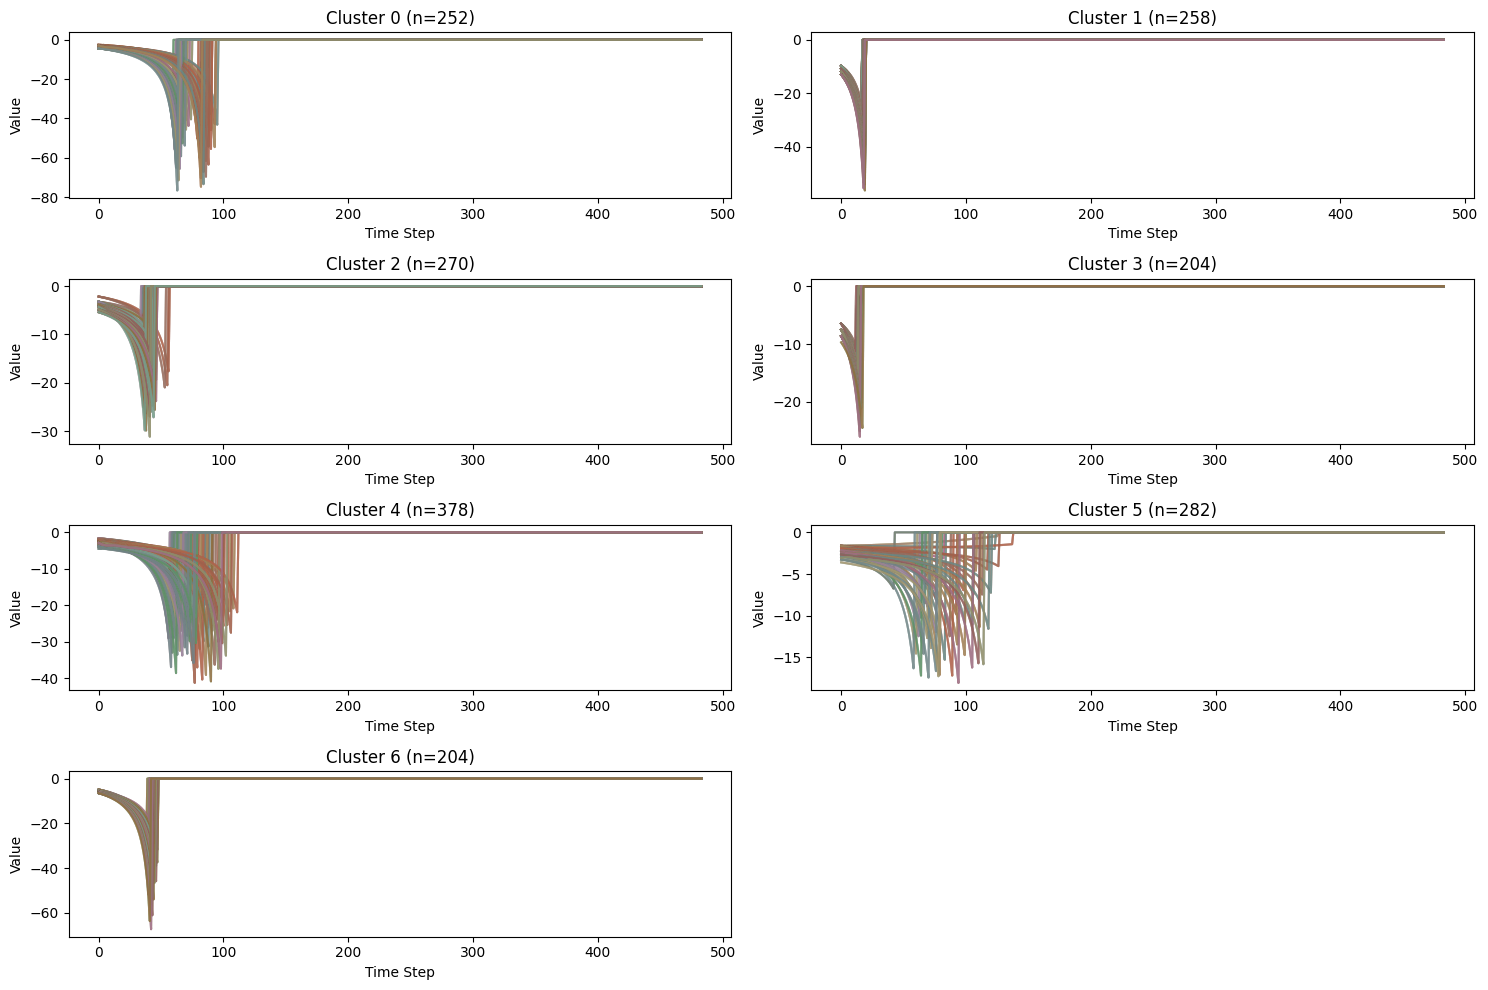

In [11]:
import matplotlib.pyplot as plt

num_clusters = len(np.unique(labels))
plt.figure(figsize=(15, 10))

for cluster in range(num_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    plt.subplot((num_clusters + 1)//2, 2, cluster + 1)

    for idx in cluster_indices:
        plt.plot(X[idx], alpha=0.3)  # plot each time series in this cluster

    plt.title(f'Cluster {cluster} (n={len(cluster_indices)})')
    plt.xlabel('Time Step')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


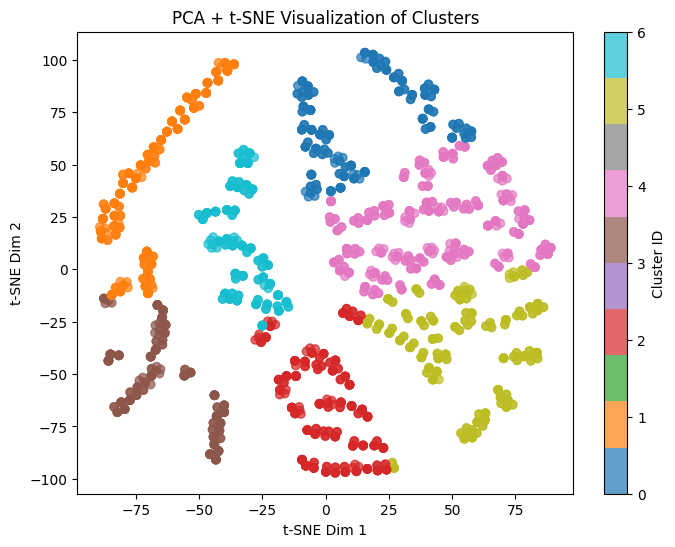

In [12]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Step 1: Reduce dimensionality with PCA first (e.g., 64D → 20D)
pca = PCA(n_components=20, random_state=0)
embeddings_pca = pca.fit_transform(embeddings)

# Step 2: Apply t-SNE on PCA-reduced embeddings
tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_pca)

# Step 3: Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=labels,   # cluster/class labels
    cmap="tab10",
    alpha=0.7
)
plt.title("PCA + t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.colorbar(scatter, label="Cluster ID")
plt.show()


<Figure size 800x500 with 0 Axes>

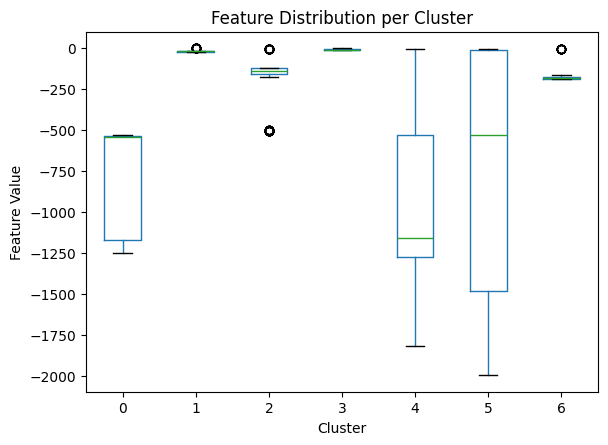

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_file_path = '/content/drive/MyDrive/Colab Notebooks/Thesis/StCfeature.csv'
feature = pd.read_csv(csv_file_path, header=None)
feature = feature.squeeze()

# Suppose you already have:
# labels -> cluster IDs (array-like)
# feature -> feature values (array-like)

# Combine into a DataFrame
df_plot = pd.DataFrame({
    'Cluster': labels,
    'Feature': feature
})

# --- Matplotlib/Pandas version ---
plt.figure(figsize=(8, 5))
df_plot.boxplot(by='Cluster', column='Feature', grid=False)
plt.title("Feature Distribution per Cluster")
plt.suptitle("")  # remove automatic title
plt.xlabel("Cluster")
plt.ylabel("Feature Value")
plt.show()